In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz import display_question, quiz_is_guaranteed_past, compute_fractional_days

/home/kavi/anaconda3/envs/urbanstats/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
plt.rcParams["font.family"] = "monospace"

In [5]:
today_problem = int(compute_fractional_days("America/New_York"))

In [6]:
result = get_full_statistics(after_problem=49, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

In [7]:
def line_histogram(offs, weights=None, dx=0.5):
    bin_sides = offs // dx * dx
    bins = np.arange(bin_sides.min(), bin_sides.max() + 1, dx)
    #     plt.hist(offs, bins=bins, alpha=0.5, label=f"J{time}; total={offs.shape[0]}")
    y, be = np.histogram(offs, weights=weights, bins=bins)
    x = (be[1:] + be[:-1]) / 2
    return x, y

In [8]:
def plot():
    plt.figure(dpi=200, facecolor="white")
    for time in range(today_problem - 2, today_problem + 1):
        offs = result[(result.problem == time) & (result.last_in_batch == 1)].offset
        if offs.shape[0] == 0:
            print(f"skipping time {time}")
            continue
        plt.plot(*line_histogram(offs), label=f"J{time}; total={offs.shape[0]}", lw=0.5)
    plt.xticks(rotation=90)
    plt.xlabel("Hours after EDT release")
    plt.ylabel("Frequency")
    lo, hi = plt.xlim()
    lo = lo // 4 * 4
    hi = hi // 4 * 4 + 4
    plt.xticks(np.arange(lo, hi + 4, 4))
    plt.grid()
    # plt.axvline(1.5, color="red", lw=0.5, label="Graph Crimes Post")
    # for h in 0, 1, 2, 3, 24, 25, 26, 27:
    #     plt.axvline(h, color="black", lw=0.5)
    plt.legend()
    plt.show()

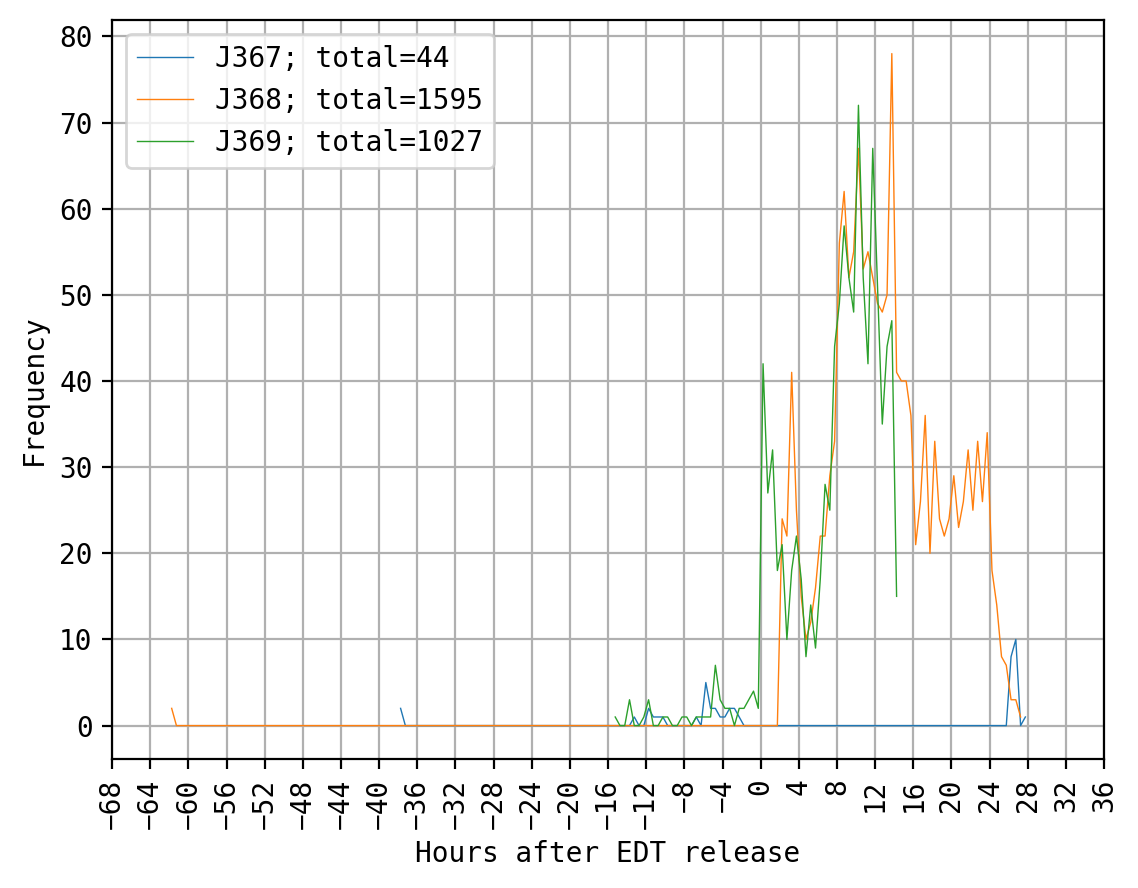

In [9]:
plot()

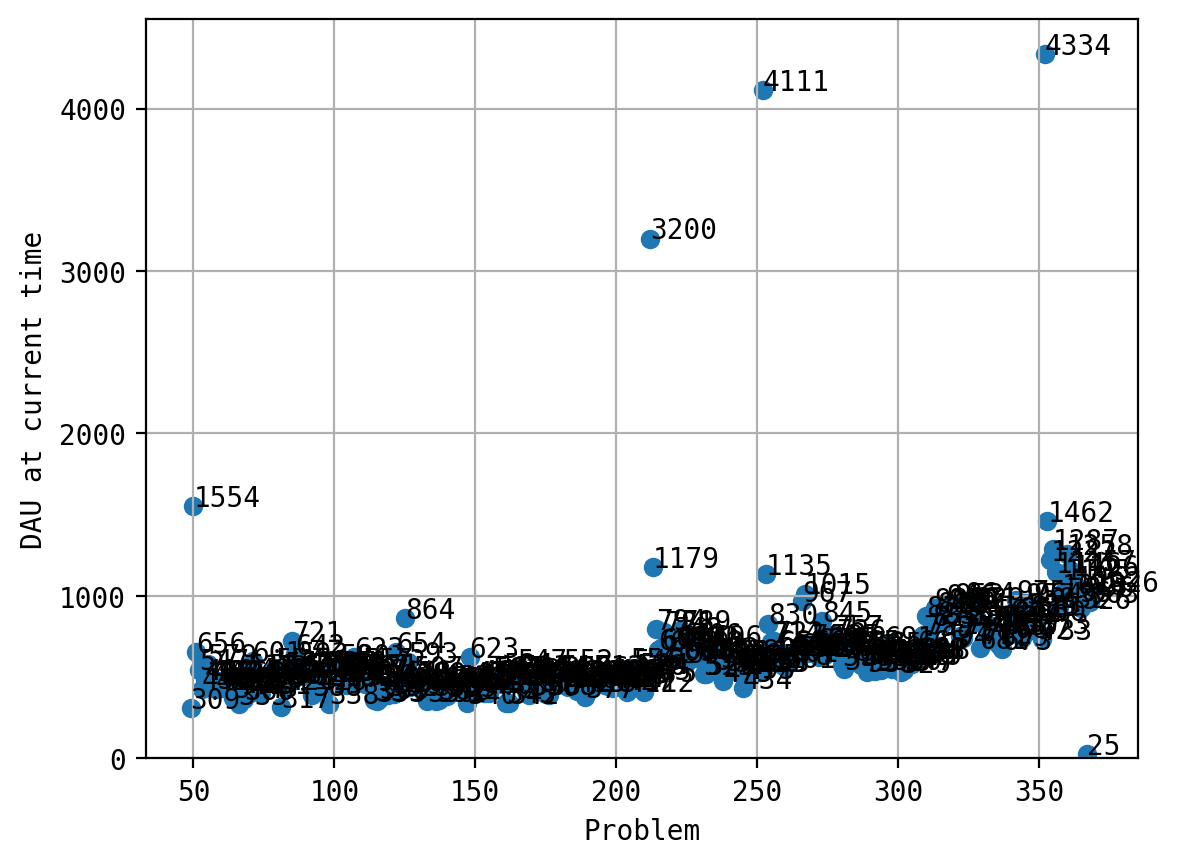

In [10]:
count_by_day = (
    result[["problem", "last_in_batch"]]
    .groupby("problem")
    .sum()
    .rename(columns={"last_in_batch": "c"})
)
today = count_by_day.index[count_by_day.c > 30].max()
time = result[result.problem == today].offset.max()
at_time = (
    result[(result.offset < time) & (result.problem <= today)]
    .groupby("problem")
    .sum()
    .last_in_batch
)
plt.figure(dpi=200)
plt.scatter(at_time.index, at_time)
for x in at_time.index:
    plt.text(s=int(at_time[x]), x=x, y=at_time[x])
plt.xlabel("Problem")
plt.ylabel("DAU at current time")
plt.ylim(0, plt.ylim()[1])
plt.grid()
plt.show()

In [11]:
def plot_juxtastat_times(compute_y, formatter=lambda x: f"{x:.0f}%", dx=0.5):
    plt.figure(dpi=200, facecolor="white")
    pre_today = result[(result.problem < today) & (result.last_in_batch == 1)].copy()
    time_all = pre_today.offset
    weights = 1 / pre_today.groupby("problem").count().user_id[pre_today.problem]
    weights /= weights.sum()
    pre_today["weight"] = list(weights)
    bins = np.arange(-14, 28 + dx, dx)
    y = []
    for xs, xe in zip(bins[:-1], bins[1:]):
        tab = pre_today[(xs <= pre_today.offset) & (pre_today.offset < xe)]
        y += [compute_y(tab)]
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array(y)
    ymax = np.nanmax(y)
    # x, y = line_histogram(time_all, weights=100 * weights, dx=0.5)
    plt.plot(x, y, lw=0.5, marker=".", color="black")
    plt.xlabel("Time in day [EDT]")
    plt.xticks([-12, -6, 0, 6, 12, 18, 24, 6])

    def span(s, e, color, name):
        plt.axvspan(s, e, alpha=0.5, color=color)
        count = compute_y(pre_today[(s <= time_all) & (time_all < e)])
        format_count = formatter(count)
        plt.text(
            x=(s + e) / 2, y=ymax * 1.1, s=f"{name}\n({format_count})", ha="center"
        )

    span(-14, 0, "#f96d6d", "Non_US")
    span(0, 6, "#5a7dc3", "Night")
    span(6, 18, "#8ac35a", "Day")
    span(18, 28, "#4e525a", "Last Minute")

    plt.ylim(0, ymax * 1.3)
    plt.grid()

Text(0, 0.5, 'User concentration in this time [%]')

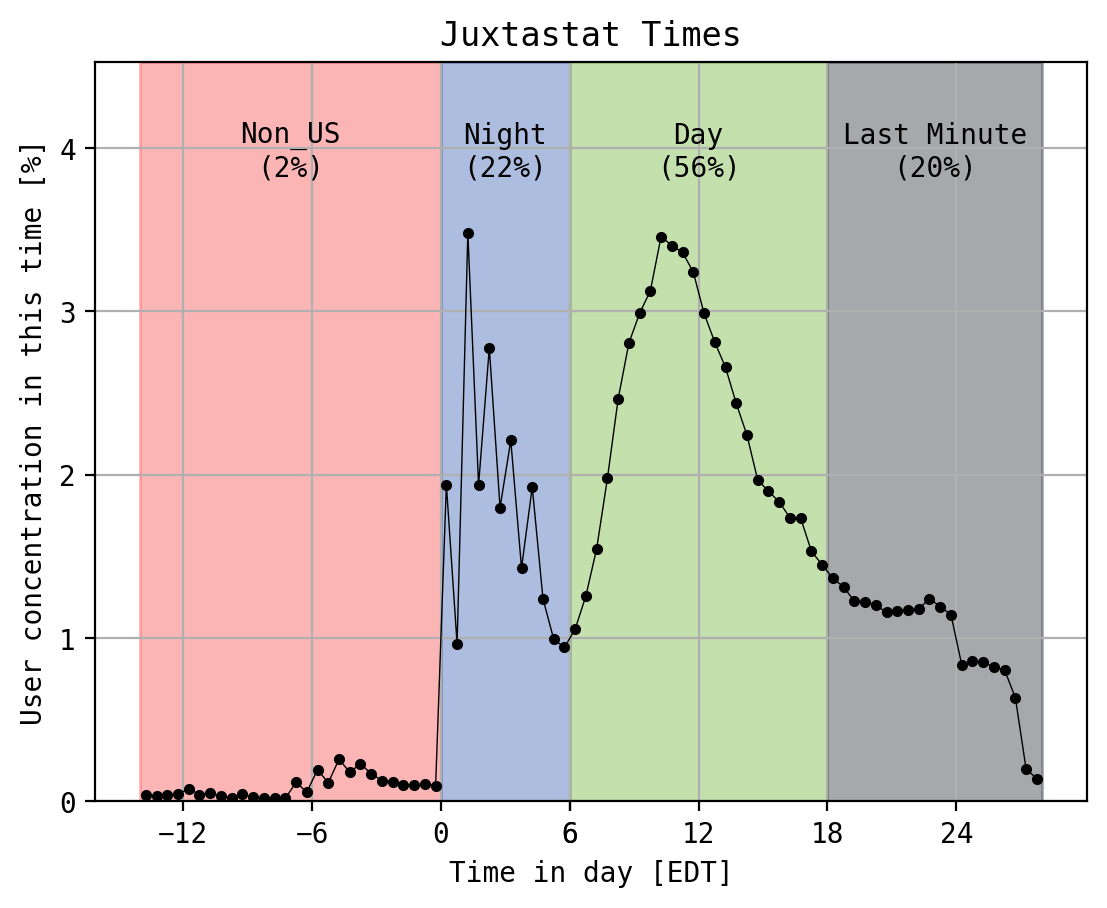

In [12]:
plot_juxtastat_times(compute_y=lambda tab: tab["weight"].sum() * 100)
plt.title("Juxtastat Times")
plt.ylabel("User concentration in this time [%]")

Text(0, 0.5, 'mean score this time')

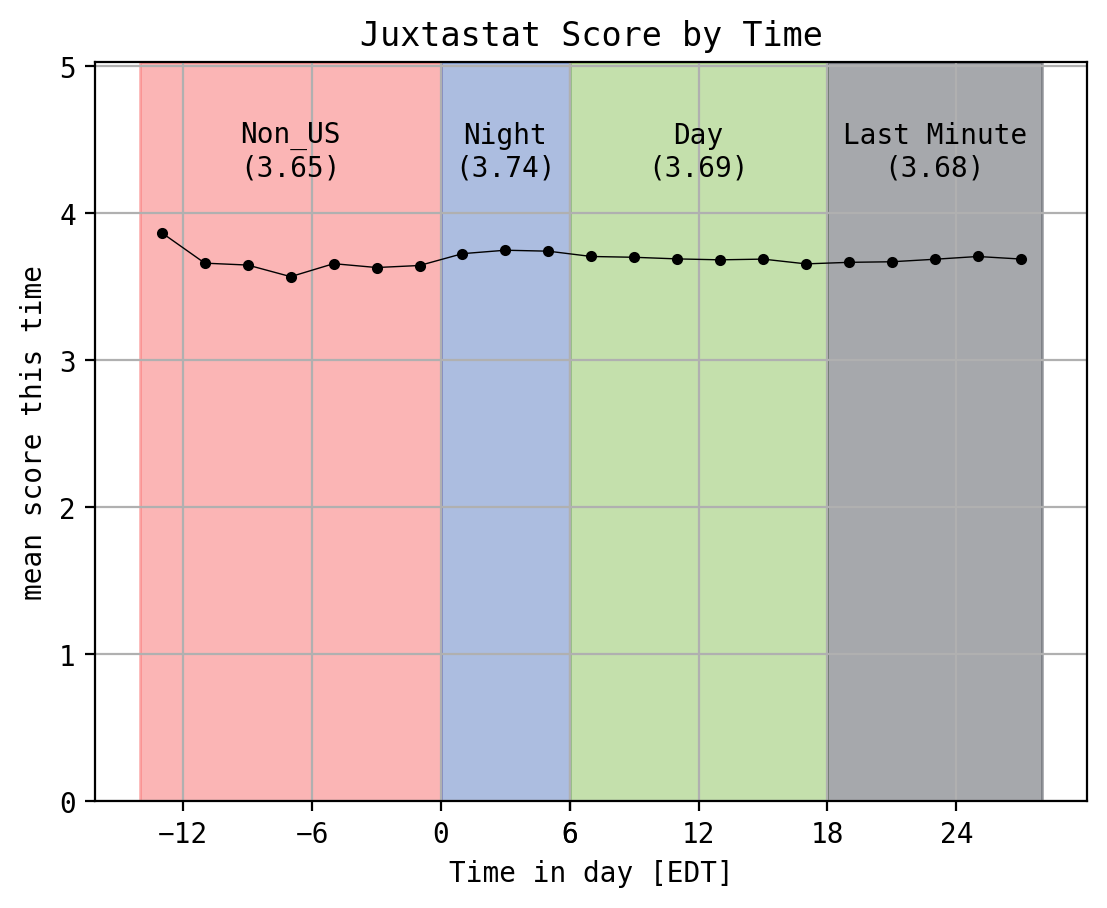

In [13]:
plot_juxtastat_times(
    compute_y=lambda tab: (tab["weight"] * tab["score"]).sum() / tab["weight"].sum()
    if tab["weight"].sum()
    else np.nan,
    formatter=lambda x: f"{x:.2f}",
    dx=2,
)
plt.title("Juxtastat Score by Time")
plt.ylabel("mean score this time")

In [14]:
is_valid_day = lambda x: quiz_is_guaranteed_past(x) is None and x > 50

In [15]:
mask = [is_valid_day(x) for x in num_users_by_problem.index]
xs, ys = num_users_by_problem.index[mask], num_users_by_problem[mask]

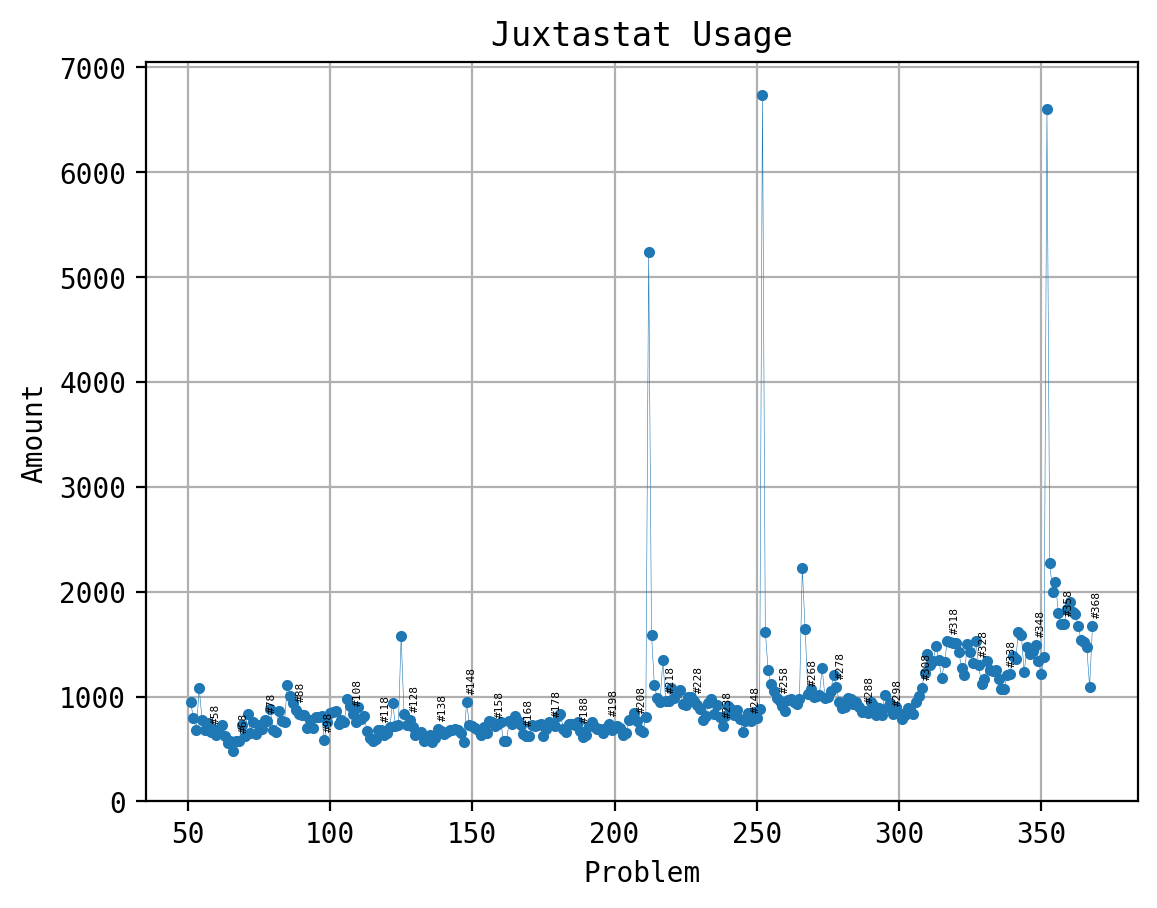

In [16]:
def plot_usage():
    plt.figure(dpi=200, facecolor="white")
    plt.title("Juxtastat Usage")
    plt.plot(xs, ys, marker=".", lw=0.2)
    plt.xlabel("Problem")
    plt.ylabel("Amount")
    plt.ylim(0, plt.ylim()[1])
    plt.grid()
    for x, y in list(zip(xs, ys))[::-10]:
        plt.text(x=x, y=y + 100, s=f"#{x}", fontsize=4, rotation=90)
plot_usage()

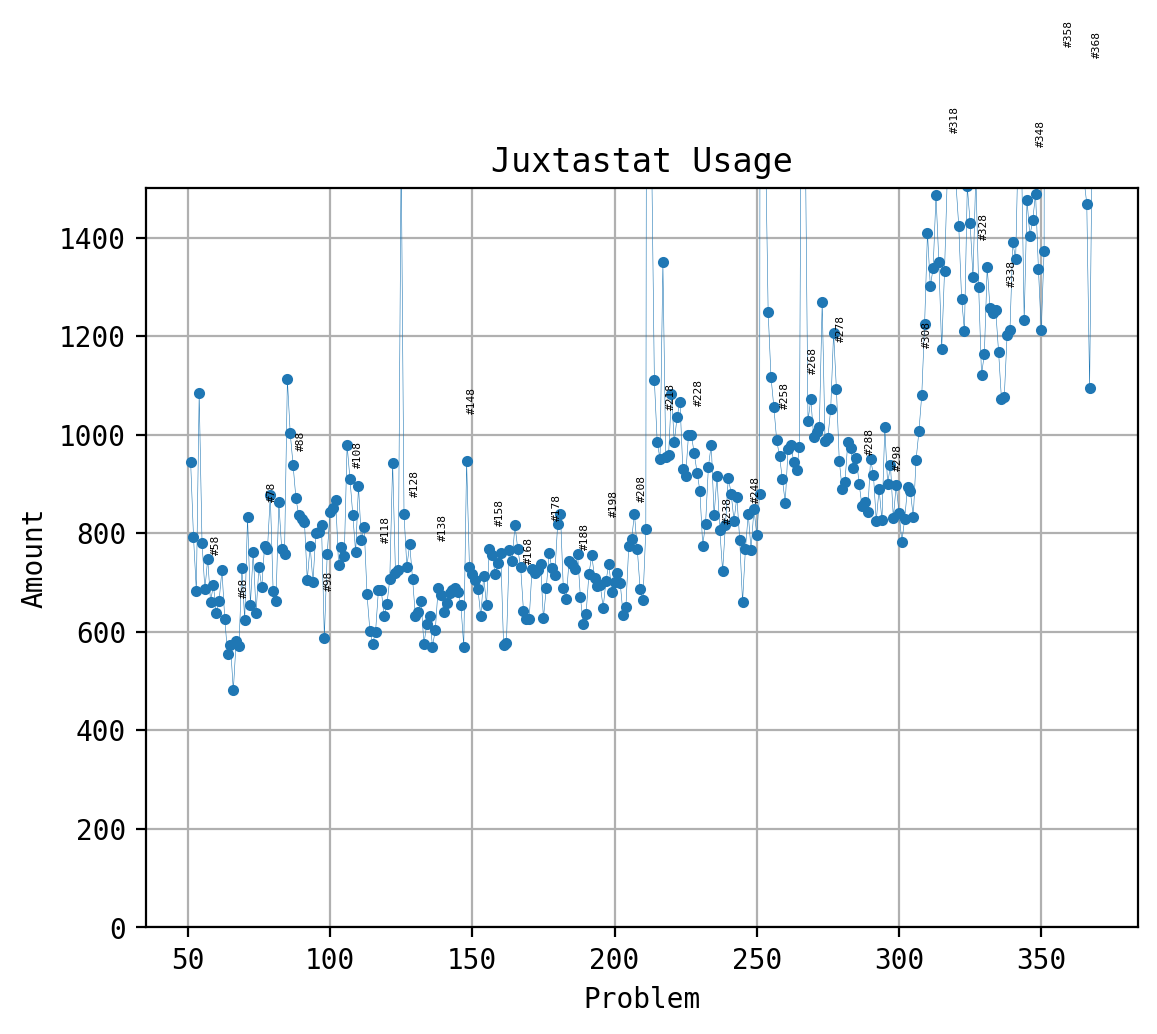

In [17]:
plot_usage()
plt.ylim(0, 1500)
plt.show()

In [18]:
def for_dow(dow):
    return ys[(xs - 1) % 7 == dow]

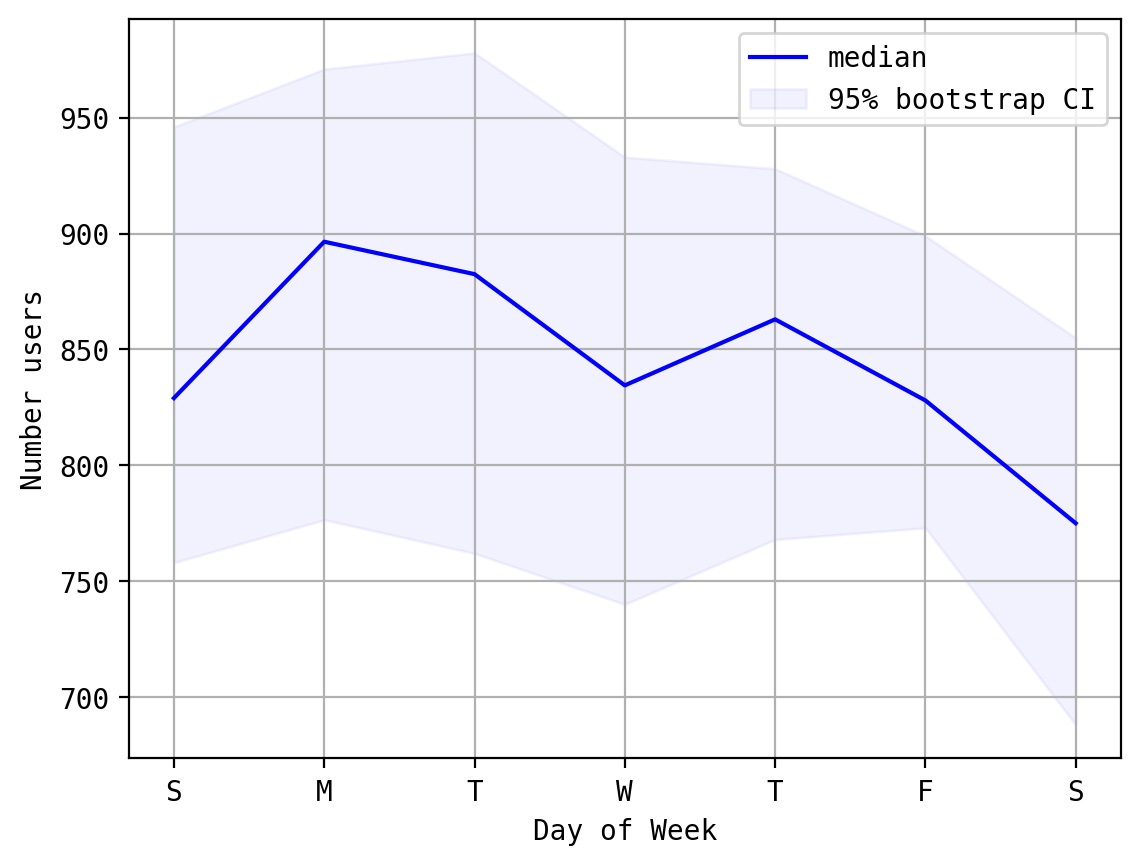

In [19]:
def summary_stats(ys):
    bootstrap = np.median(np.random.RandomState(0).choice(ys, replace=True, size=(10000, ys.shape[0])), 1)
    return np.percentile(bootstrap, [2.5, 50, 97.5])
lo, me, hi = np.array([summary_stats(for_dow(dow)) for dow in range(7)]).T
plt.figure(dpi=200)
x = np.arange(7)
plt.plot(x, me, color="blue", label="median")
plt.fill_between(x, lo, hi, color="blue", alpha=0.05, label="95% bootstrap CI")
plt.xticks(x, list("SMTWTFS"))
plt.ylabel("Number users")
plt.xlabel("Day of Week")
plt.legend()
plt.grid()
plt.show()

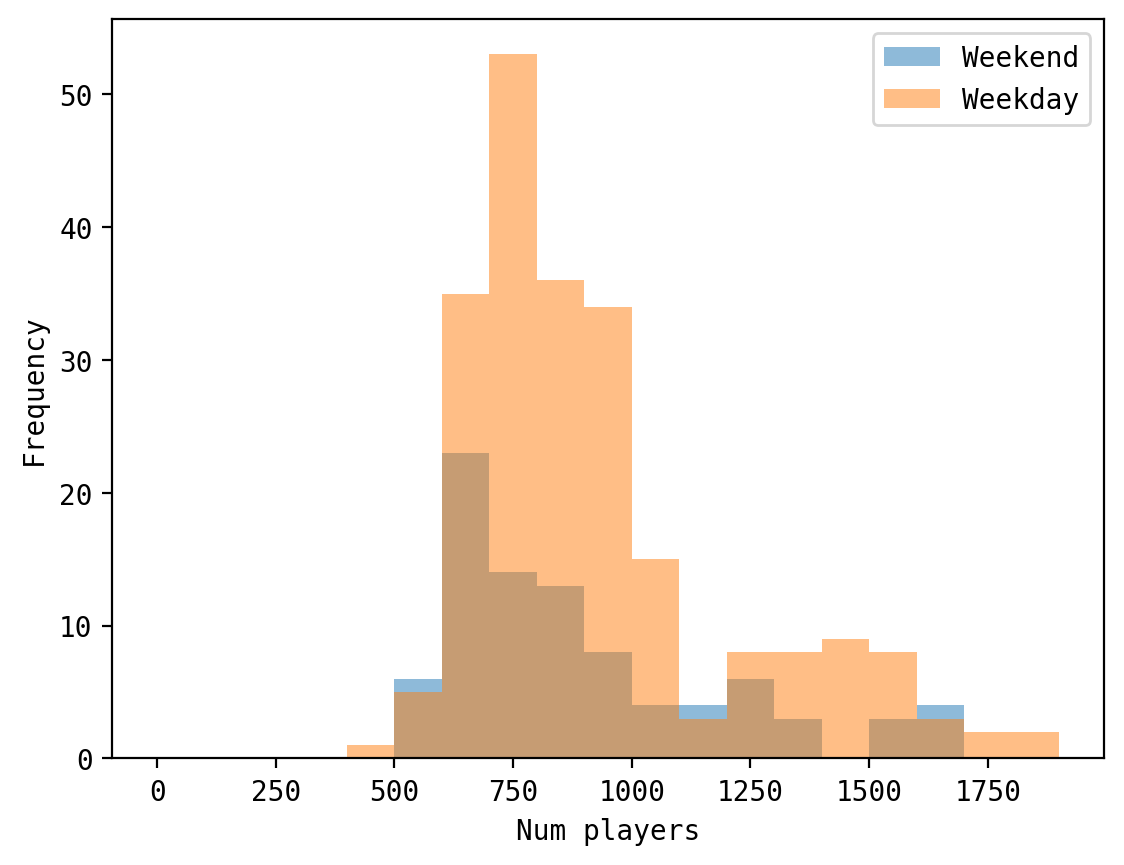

In [20]:
plt.figure(dpi=200, facecolor="white")
bins = np.arange(0, 2000, 100)
plt.hist([x for dow in [0, 6] for x in for_dow(dow)], bins=bins, alpha=0.5, label="Weekend")
plt.hist([x for dow in range(1, 1 + 5) for x in for_dow(dow)], bins=bins, alpha=0.5, label="Weekday")
plt.legend()
plt.xlabel("Num players")
plt.ylabel("Frequency")
plt.show()

In [21]:
import sklearn.linear_model

0.007354009779817261


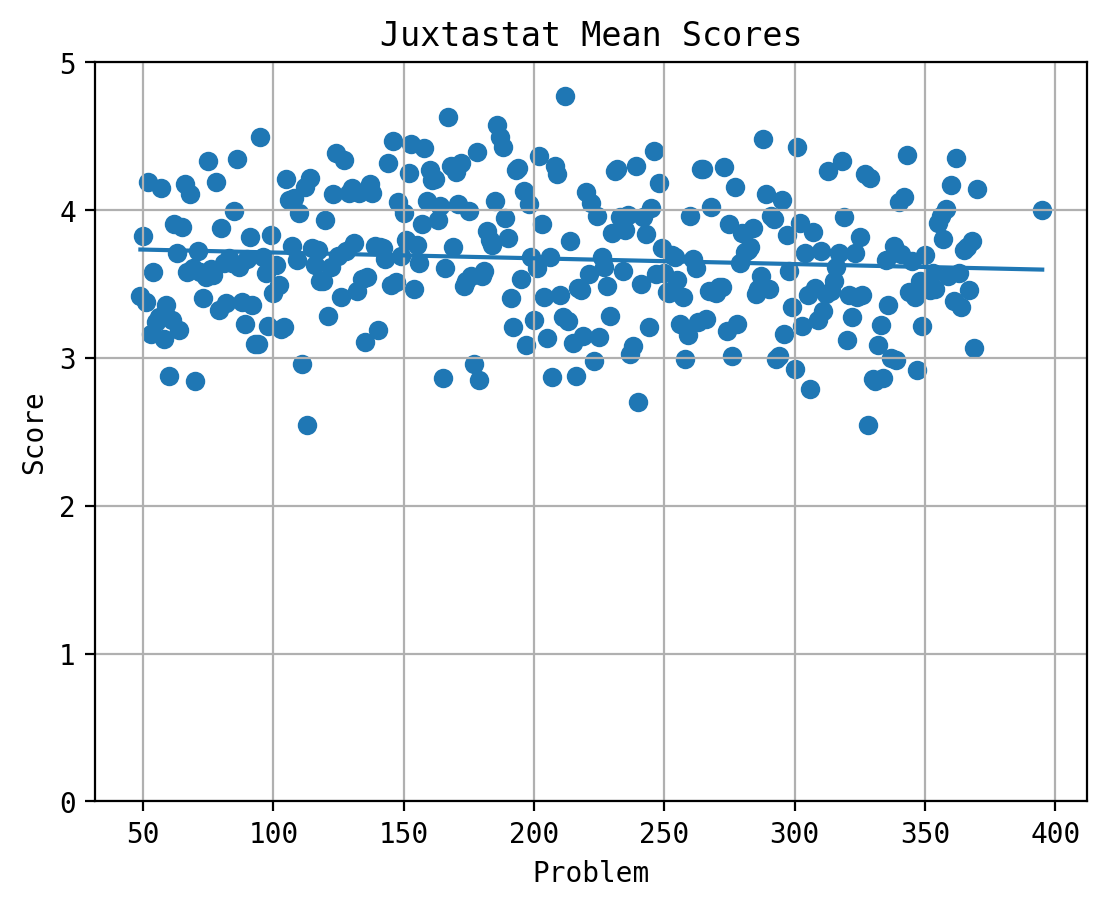

In [22]:
plt.figure(dpi=200, facecolor="white")
plt.title("Juxtastat Mean Scores")
plt.scatter(means.index, means.score)
x = np.array(means.index)[:, None]
lin = sklearn.linear_model.LinearRegression().fit(
    x, means.score
)
[m], b = lin.coef_, lin.intercept_
print(lin.score(x, means.score))
plt.plot(means.index, m * means.index + b)
plt.ylim(0, 5)
plt.xlabel("Problem")
plt.ylabel("Score")
plt.grid()

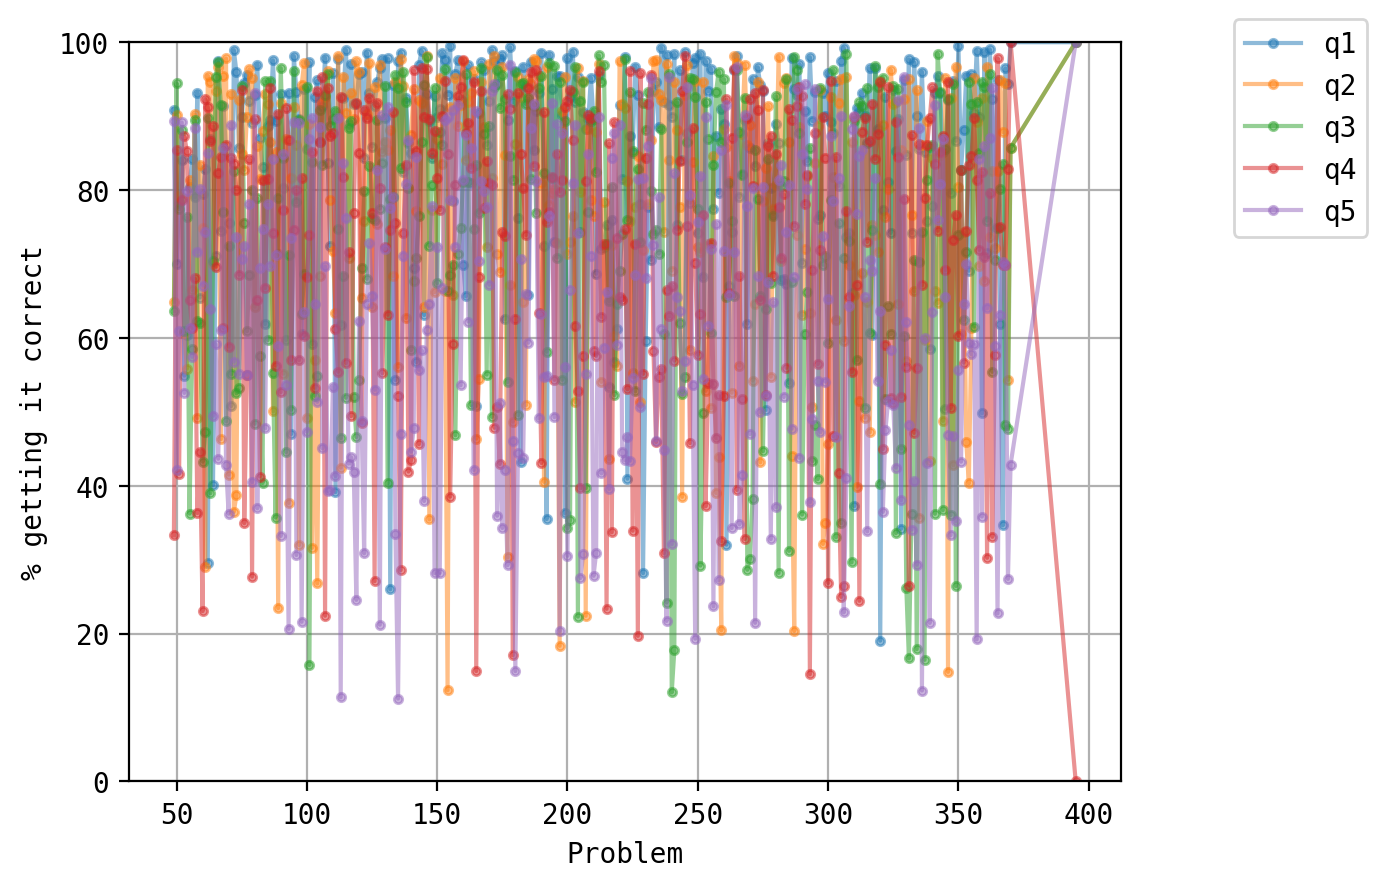

In [23]:
plt.figure(dpi=200)
for q in questions:
    plt.plot(means.index, 100 * means[q], label=q, marker=".", alpha=0.5)
plt.ylim(0, 100)
plt.xlabel("Problem")
plt.ylabel("% getting it correct")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

In [24]:
from datetime import timedelta
import pandas as pd

In [25]:
flat_qs = pd.DataFrame(
    dict(
        correct=np.concatenate([means[question] for question in questions]),
        problem=np.concatenate([means[question].index for question in questions]),
        idx=np.concatenate(
            [
                np.zeros_like(means[question], dtype=np.long) + i
                for i, question in enumerate(questions)
            ]
        ),
    )
).sort_values("correct")
flat_qs["count"] = np.array(result.groupby("problem").count().user_id[flat_qs.problem])

In [26]:
def display_row(row):
    result = f"{row.correct:.0%} correct."
    result += f" Juxtastat {row.problem:.0f} q{row.idx + 1:.0f}\n"
    with open(f"/home/kavi/temp/site/quiz/{row.problem:.0f}") as f:
        q = json.load(f)[int(row.idx)]
    result += "  " + display_question(q["question"])
    result += "\n    a) " + q["longname_a"]
    result += "\n    b) " + q["longname_b"]
    return result

In [27]:
for i, (_, worst) in enumerate(flat_qs[:5].iterrows(), 1):
    print(f"{i}th worst performance: " + display_row(worst))

1th worst performance: 0% correct. Juxtastat 395 q4
  Which has a higher % of workers employed in the educational services industry!TOOLTIP elementary and secondary schools, colleges, universities,etc.?
    a) Durham city, North Carolina, USA
    b) Mesa city, Arizona, USA
2th worst performance: 11% correct. Juxtastat 135 q5
  Which has more hours of sun per day on average? (population weighted)
    a) DC Circuit, USA
    b) 1st Circuit, USA
3th worst performance: 11% correct. Juxtastat 113 q5
  Which has a higher % of people who commute by bike?
    a) 1st Circuit, USA
    b) 10th Circuit, USA
4th worst performance: 12% correct. Juxtastat 240 q3
  Which has a higher mean daily high temperature in summer (population weighted)?
    a) Chula Vista city, California, USA
    b) Columbus city, Ohio, USA
5th worst performance: 12% correct. Juxtastat 336 q5
  Which has a higher % of people who are renters?
    a) North Dakota, USA
    b) Tennessee, USA


In [28]:
for i, (_, worst) in enumerate(flat_qs[::-1][:5].iterrows(), 1):
    print(f"{i}th best performance: " + display_row(worst))

1th best performance: 100% correct. Juxtastat 395 q5
  Which has a higher % of adults with a cognitive disability?
    a) LA-05, USA
    b) FL-25, USA
2th best performance: 100% correct. Juxtastat 395 q2
  Which has a higher % of households who have household income over $100k?
    a) Puerto Rico, USA
    b) New Mexico, USA
3th best performance: 100% correct. Juxtastat 395 q3
  Which has a higher % of people who have commute time over 60 min?
    a) Cleveland-Elyria MSA, OH, USA
    b) Merced MSA, CA, USA
4th best performance: 100% correct. Juxtastat 370 q1
  Which has a higher % of units with 1br rent under $750?
    a) OR-05, USA
    b) AL-04, USA
5th best performance: 100% correct. Juxtastat 395 q1
  Which has a higher % of days with wind speed over 10mph (population weighted)!TOOLTIP Population weighted weather statistics are calculated by computing the weather statistic for each person in the region and then averaging the results.?
    a) Lubbock TX Media Market, USA
    b) Wilkes

In [29]:
result_time_relevant = result[result.last_in_batch == 1]

In [30]:
count_by_user_id = result_time_relevant.groupby("user_id").count().time
users = count_by_user_id.index[count_by_user_id > 5]

(array([7.7541e+04, 8.7000e+02, 3.1100e+02, 1.7100e+02, 1.0500e+02,
        5.6000e+01, 3.3000e+01, 3.6000e+01, 3.2000e+01, 3.5000e+01]),
 array([  1. ,  32.9,  64.8,  96.7, 128.6, 160.5, 192.4, 224.3, 256.2,
        288.1, 320. ]),
 <BarContainer object of 10 artists>)

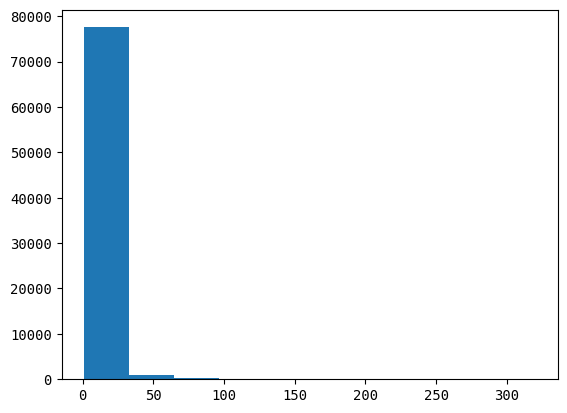

In [31]:
plt.hist(count_by_user_id)

In [32]:
times_sorted = np.array([x.timestamp() for x in sorted(result_time_relevant.time)])
time_to_index = {k : i for i, k in enumerate(times_sorted)}
def count_in_range(start, end):
    return np.searchsorted(times_sorted, end.timestamp()) - np.searchsorted(times_sorted, start.timestamp())
    return result_time_relevant[
        (start < result_time_relevant.time) & (result_time_relevant.time < end)
    ].shape[0]

In [33]:
from collections import defaultdict
time_by_user = defaultdict(list)
for u, t in zip(result_time_relevant.user_id, result_time_relevant.time):
    time_by_user[u].append(t)

In [34]:
named_users = dict(
    vo=1000233398257748901,
    avery=1027246234047181785,
    kavi=225074120239201340,
    guava=533487794723891791,
    parth=232188494395851367,
#     gus=65416843712317322,
    adiastra=727538863697858149,
    ellie=691958428450574907,
    sleepy=19800660824996662,
    antifa=1128140214864259863,
#     ashjubilee=846814263642105530,
    april=0x1d2efe90871f22b,
    violetncs=0x523ff09c66f52f4,
)
id_to_name = {k : v for v, k in named_users.items()}

In [35]:
s = 60

In [36]:
by_user = {}
for user in tqdm.tqdm(users):
    before = after = 0
    for t in time_by_user[user]:
        before += count_in_range(t - timedelta(seconds=s), t)
        after += count_in_range(t, t + timedelta(seconds=s))
    by_user[user] = dict(after=after, before=before, delta=after - before, ratio=after/before)

  0%|          | 0/7070 [00:00<?, ?it/s]

/home/kavi/anaconda3/envs/urbanstats/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


In [37]:
by_ratio = pd.DataFrame(by_user).T.sort_values("delta")[::-1]
by_ratio.index = [id_to_name.get(x, hex(x)[2:]) for x in by_ratio.index]

In [38]:
by_ratio[:10]

,after,before,delta,ratio
vo,649.0,255.0,394.0,2.545098
c894f182d0236f5,771.0,396.0,375.0,1.946970
26fb17d5bf0c5b4,646.0,277.0,369.0,2.332130
cb49d043faaf2d,666.0,305.0,361.0,2.183607
ea570a85ed7f87f,556.0,197.0,359.0,2.822335
845098ee28f1b,584.0,227.0,357.0,2.572687
f7fc94ed86a4937,631.0,288.0,343.0,2.190972
6c60a759d1529d9,543.0,216.0,327.0,2.513889
fd060c8a15a95fe,501.0,175.0,326.0,2.862857
parth,607.0,282.0,325.0,2.152482


In [39]:
result_full = get_full_statistics(after_problem=1, debug=False)

In [40]:
def query(*days_patterns):
    result = [
        result_full[
            (result_full.problem == day)
            & (result_full.pattern.apply(lambda x: x.tolist() == pattern))
        ].user_id
        for day, pattern in days_patterns
    ]
    result = [set(x) for x in result]
    from collections import Counter
    ctr = Counter(x for xs in result for x in xs)
    ctr = sorted(ctr.items(), key=lambda x: -x[1])
    return [(id, c - len(days_patterns), c / len(days_patterns)) for id, c in ctr]

In [41]:
# query(
# #     [271, [1, 1, 1, 1, 1]],
#     [268, [1, 1, 1, 0, 1]],
#     [267, [1, 1, 1, 0, 1]],
#     [266, [1, 0, 1, 1, 1]],
#     [265, [1, 1, 1, 1, 1]],
#     [264, [1, 1, 1, 1, 1]],
#     [263, [0, 0, 1, 1, 1]],
# )

In [42]:
count_by_user_id_full = result_full.groupby("user_id").count().time

In [43]:
gaps = []
for uid in tqdm.tqdm(sorted(set(count_by_user_id_full.index[count_by_user_id_full > 1]))):
    days = np.array(sorted(set(result_full[result_full.user_id == uid].problem)))
    gaps += [(days[1:] - days[:-1]).max()]

  0%|          | 0/20896 [00:00<?, ?it/s]

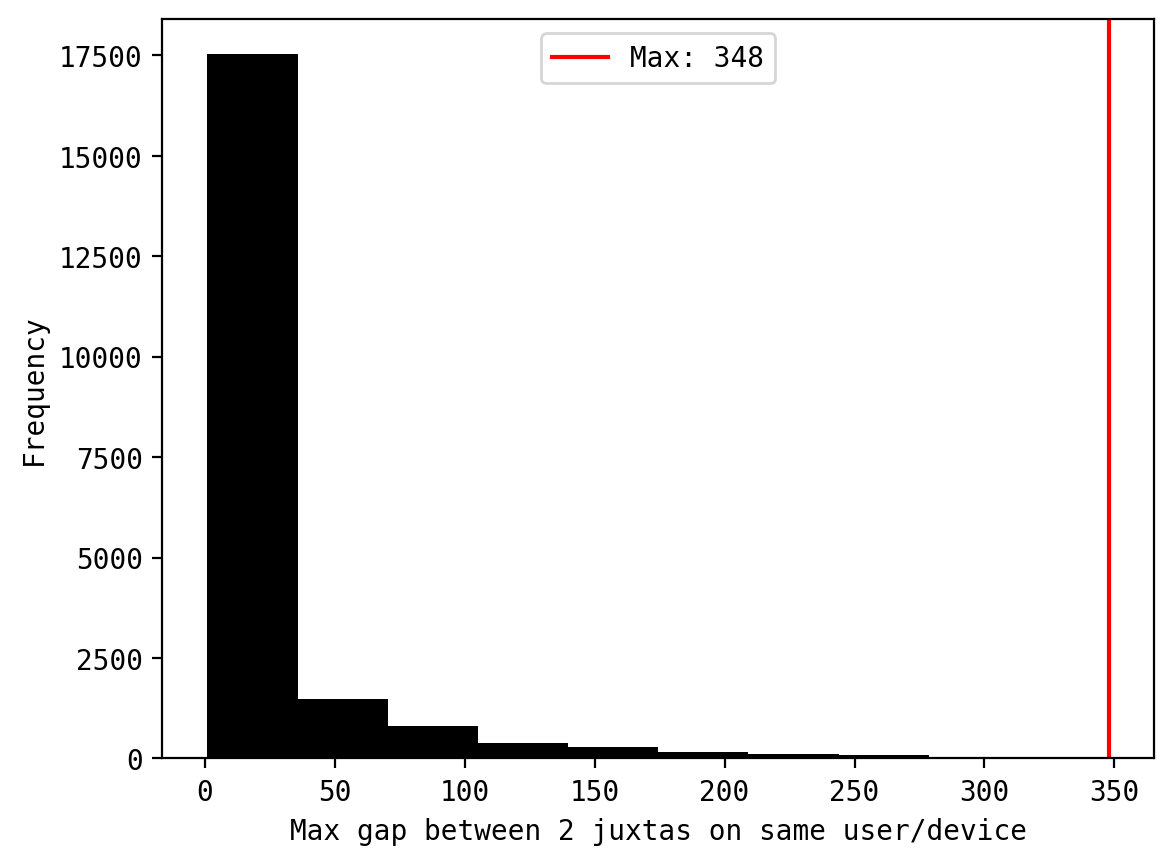

In [44]:
plt.figure(dpi=200, facecolor="white")
plt.hist(gaps, color="black")
plt.xlabel("Max gap between 2 juxtas on same user/device")
plt.ylabel("Frequency")
plt.axvline(max(gaps), label=f"Max: {max(gaps)}", color="red")
plt.legend()
plt.show()

In [45]:
distro = (
    result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]
    .groupby("user_id")
    .mean()
    .score
)
counts = (
    result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]
    .groupby("user_id")
    .count()
    .score
)

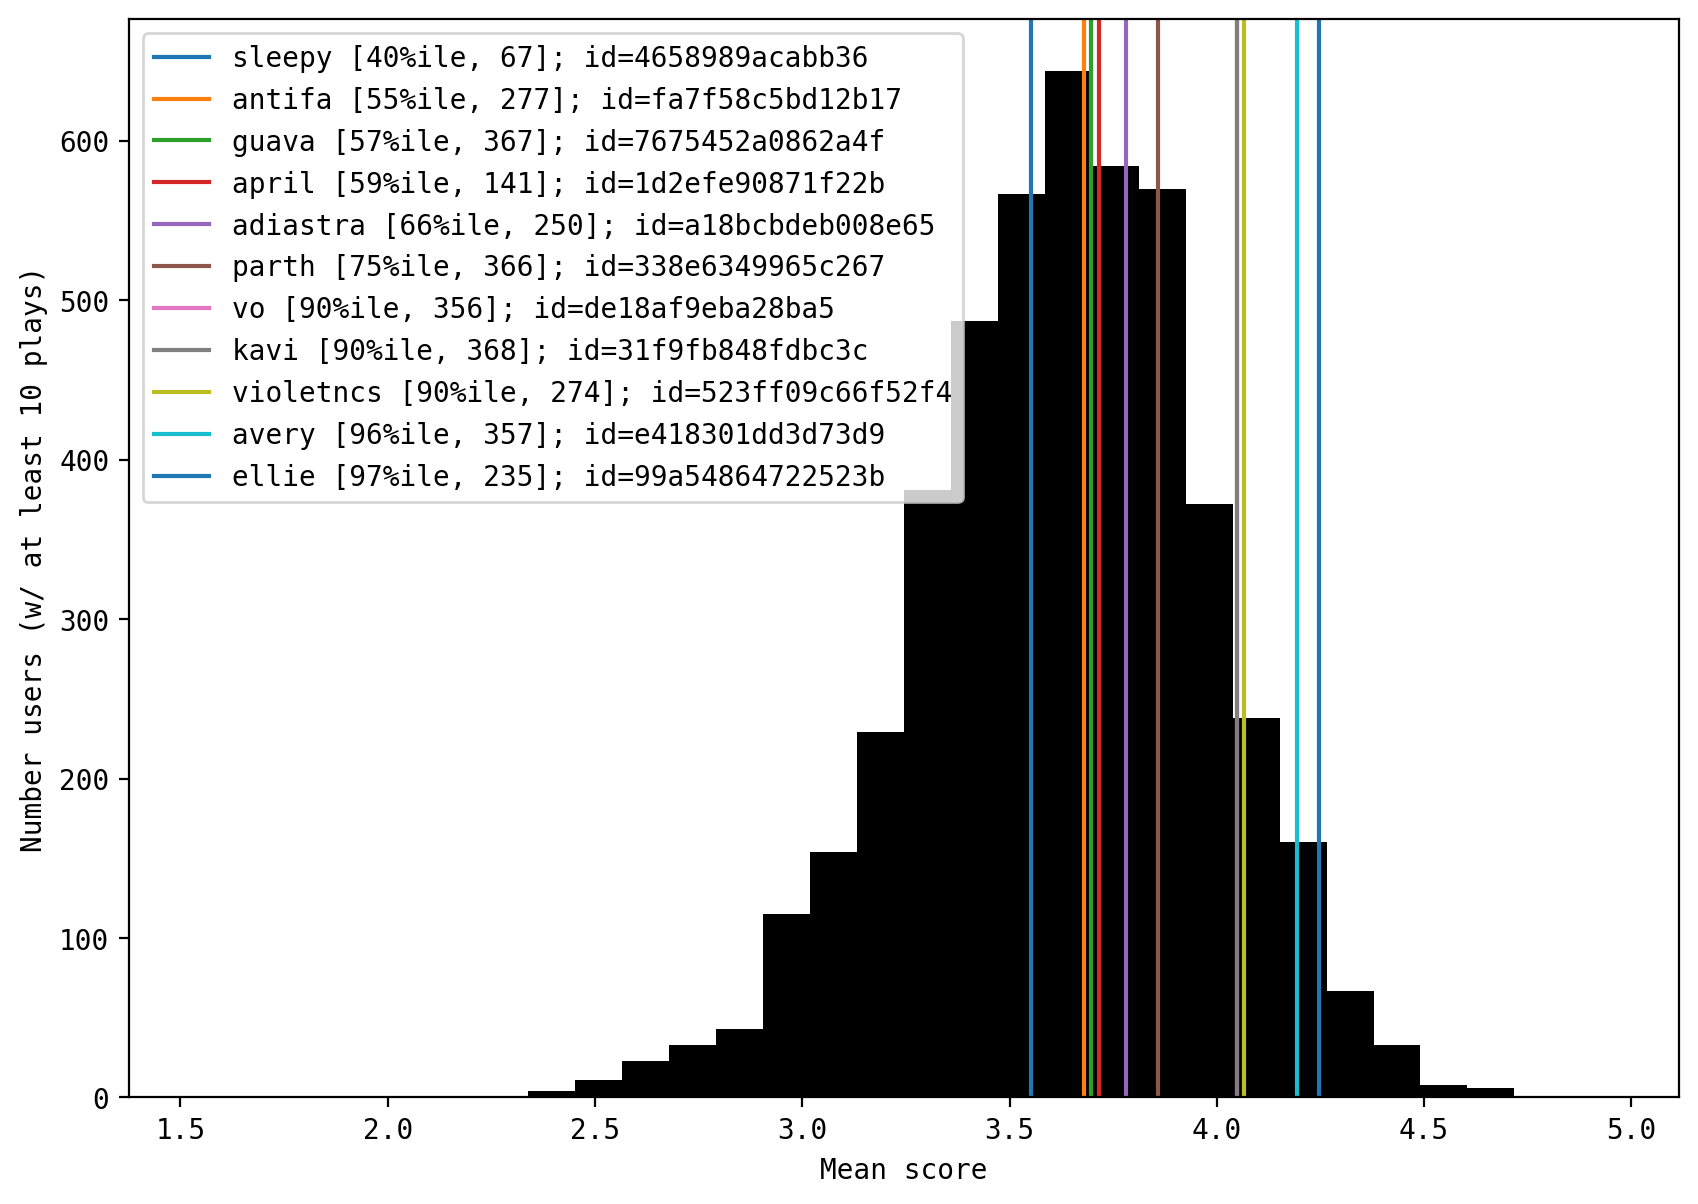

In [46]:
plt.figure(dpi=200, facecolor="white", figsize=(10, 7))
plt.hist(distro, bins=30, color="black")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
for k, color in zip(sorted(named_users, key=lambda x: distro[named_users[x]]), colors):
    plt.axvline(
        distro[named_users[k]],
        label=f"{k} [{(distro < distro[named_users[k]]).mean() * 100:.0f}%ile, {counts[named_users[k]]}]; id={hex(named_users[k])[2:]}",
        color=color,
    )
plt.xlabel("Mean score")
plt.ylabel("Number users (w/ at least 10 plays)")
plt.legend()
plt.show()

In [47]:
(result_full.score == 5).groupby(result_full.problem).mean().sort_values()[::-1][:10] * 100

problem
212    83.346051
6      75.167785
167    72.229822
186    67.032967
187    63.720317
95     60.799001
10     59.459459
288    59.375000
301    58.748404
188    56.631893
Name: score, dtype: float64

In [48]:
lefts, rights = 0, 0
lefts_bad, rights_bad = 0, 0
for problem in sorted(set(result_full.problem)):
    if problem < 100:
        continue
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        q = json.load(f)
        left_correct = np.array([x["stat_a"] > x["stat_b"] for x in q])
    for_p = result_full[result_full.problem == problem]
    overall_correct = np.array(for_p[questions].sum())
    lefts += overall_correct[left_correct].sum()
    rights += overall_correct[~left_correct].sum()
    lefts_bad += (for_p.shape[0] - overall_correct)[left_correct].sum()
    rights_bad += (for_p.shape[0] - overall_correct)[~left_correct].sum()
#     count += 1
# left_correct /= count
# overall_correct /= count